# TrendFollowingBot

A pragmatic trend-following strategy that pairs **EMA trend detection** with two simple, complementary entry patterns:

1) a **crossback** into trend (price crosses the EMA and the very next bar opens on the trend side), and  
2) an **ATR-scaled breakout** away from the EMA (current open is beyond the EMA by *k × ATR*).

Exits (initial stop, trail/TP) and sizing are delegated to the shared bot base via your chosen **ExitStrategy** (e.g., `TrailingATRExit`, `FixedRatioExit`), so this class focuses purely on **when to enter**. It reads signals from the **previous closed bar** and places orders at the **current bar open** to avoid look-ahead. :contentReference[oaicite:0]{index=0}

---

## Overview

- **Goal:** Participate in sustained moves while avoiding most chop by requiring either a *confirmed* cross of the trend filter (EMA) or enough **volatility-adjusted distance** from it.  
- **Trend filter:** Exponential moving average of length **`trend_ema_span`** (default **50**).  
- **Volatility gate:** **ATR** from the prior closed bar; **`breakout_atr_mult`** (default **1.5**) scales how far from the EMA price must be to count as a breakout.  
- **Signal timing:** Compute on **bar *t-1***; place the order at the **open of bar *t*** (no look-ahead).  
- **Exits & sizing:** Inherited from the base strategy (risk %, SL/TP policy, trailing logic).  
- **Data requirements:** The dataframe must include an EMA column named `ema_{trend_ema_span}` (e.g., `ema_50`) and an ATR series used by the base bot.

---

## Algorithm & Entry Logic

Let:
- `ema_prev` = EMA value on the **previous (closed) bar**  
- `prev_close` = prior bar’s close  
- `entry_open` = **current bar open** (where your order will execute)  
- `atr_prev` = prior bar’s ATR (from the base helper)

**1) Crossback into trend**  
- **Long:** `prev_close ≤ ema_prev` **and** `entry_open > ema_prev` → `buy`  
- **Short:** `prev_close ≥ ema_prev` **and** `entry_open < ema_prev` → `sell`

This insists the trend filter is **actually crossed** and that the **very next open** is on the trend side—reducing whipsaw from intrabar pokes.

**2) EMA-±(k × ATR) breakout**  
Compute a volatility buffer: `threshold = breakout_atr_mult × atr_prev`.

- **Long:** `entry_open > ema_prev + threshold` → `buy`  
- **Short:** `entry_open < ema_prev − threshold` → `sell`

If neither rule fires, the bot stays flat for that bar.

---

## Key Parameters

| Param                | Default | What it does                                                                 |
|---------------------:|:-------:|-------------------------------------------------------------------------------|
| `trend_ema_span`     |   50    | Length of the EMA trend filter (expects a column named `ema_50`, etc.).      |
| `breakout_atr_mult`  |  1.5    | Volatility buffer (in ATRs) required for the EMA-distance breakout entries.  |

> Tuning tips: Smaller `breakout_atr_mult` captures more breakouts (higher turnover, more noise). Larger values trade less but target stronger impulses. Shorter `trend_ema_span` reacts faster (more trades), longer spans are steadier.

---

## Notes on Exits & Risk

This bot **only** decides *side/entry*. Stops, trailing, take-profits, and position sizing are handled by the shared base (`BaseStrategyBot`) through the configured `ExitStrategy`—so you can mix and match exits (e.g., ATR-trailing) without rewriting entry logic. :contentReference[oaicite:1]{index=1}

## Assests Included in Portfolio

| Assest name    | Notebook symbol (example) | Comment                         |
|----------------|---------------------------|---------------------------------|
| Gold           | `GC=F`                    | COMEX Gold                      |
| Silver         | `SI=F`                    | COMEX Silver                    |
| U.S. Bonds     | `ZB=F`                    | 30-Year Treasury Bond           |
| Crude Oil      | `CL=F`                    | NYMEX WTI                       |
| Soybeans       | `ZS=F`                    | CBOT Soybeans                   |
| Deutsche Mark  | `6E=F`                    | Euro FX as successor to DEM     |
| British Pound  | `6B=F`                    | British Pound FX                |
| Live Cattle    | `LE=F`                    | CME Live Cattle                 |


## Setup

In [1]:
# jump to repo root (fallback: parent if in notebooks/)
ROOT = !git rev-parse --show-toplevel 2>/dev/null
%cd {ROOT[0] if ROOT else '..'}


/home/dennis/Algo-Trading-Stack


In [2]:
!./setup/fetch_sample_portfolio_futures_data.sh

========== Last 10 years ==========
⏭️  Gold: already exists, skipping.
⏭️  Silver: already exists, skipping.
⏭️  Crude_Oil: already exists, skipping.
⏭️  Soybeans: already exists, skipping.
⏭️  Sugar: already exists, skipping.
⏭️  US_Treasury_Bonds: already exists, skipping.
⏭️  Euro: already exists, skipping.
⏭️  British_Pound: already exists, skipping.
⏭️  Live_Cattle: already exists, skipping.
========== Last 20 years ==========
⏭️  Gold: already exists, skipping.
⏭️  Silver: already exists, skipping.
⏭️  Crude_Oil: already exists, skipping.
⏭️  Soybeans: already exists, skipping.
⏭️  Sugar: already exists, skipping.
⏭️  US_Treasury_Bonds: already exists, skipping.
⏭️  Euro: already exists, skipping.
⏭️  British_Pound: already exists, skipping.
⏭️  Live_Cattle: already exists, skipping.
========== 2000 to 2015 ==========
⏭️  Gold: already exists, skipping.
⏭️  Silver: already exists, skipping.
⏭️  Crude_Oil: already exists, skipping.
⏭️  Soybeans: already exists, skipping.
⏭️  Suga

In [3]:
# Enable autoreload (useful while iterating), and hook Qt into Jupyter
%load_ext autoreload
%autoreload 2
%gui qt


## Project root & imports

Set the project root if your notebook isn't at the repo root. By default, we assume the notebook lives in the root (where `classes/` and `bots/` exist).


In [4]:
import sys, os, pathlib
PROJECT_ROOT = os.path.abspath('.') 
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
print('PROJECT_ROOT =', PROJECT_ROOT)

os.chdir(PROJECT_ROOT)
print("Current working directory:", os.getcwd())



PROJECT_ROOT = /home/dennis/Algo-Trading-Stack
Current working directory: /home/dennis/Algo-Trading-Stack


In [5]:
from PyQt5 import QtWidgets
import gc

from classes.Backtester_Engine import BacktesterEngine
from classes.Trading_Environment import TradingEnvironment
from classes.ui_main_window import launch_gui

# Bots
from bots.coin_flip_bot.coin_flip_bot import CoinFlipBot
from bots.trend_following_bot.trend_following_bot import TrendFollowingBot

# Exits
from bots.exit_strategies import TrailingATRExit, FixedRatioExit


## Build the exit strategy

In [6]:
exit_strategy = TrailingATRExit(atr_multiple=3.0)

## Build the bot

In [7]:
bot = TrendFollowingBot(
    exit_strategy=exit_strategy,
    base_risk_percent=0.01,
    enforce_sessions=False,
    flatten_before_maintenance=True,
    enable_online_learning=False
)

## Initialize engine and environment

In [8]:
config_path = "backtest_configs/backtest_config_10_yrs.yaml"

api = BacktesterEngine(config_path=config_path)
api.connect()

env = TradingEnvironment()
env.set_api(api)
env.set_bot(bot)

# Initial indicator compute happens inside TradingEnvironment on connect.
print('Assets:', env.get_asset_list())


Assets: ['6B=F', 'CL=F', '6E=F', 'GC=F', 'LE=F', 'SI=F', 'ZS=F', 'ZB=F']


## Launch GUI and Run Backtest

This starts the backtest control panel and charting UI. You can open charts, start/pause/restart, and view statistics.
If the window doesn't appear from within Jupyter, ensure you ran `%gui qt` above, or run this notebook locally (VS Code, JupyterLab).


In [9]:
launch_gui(env, api)

[FORCED LIQUIDATION] 6B=F: current qty=9, submitting side=sell, qty=9
[FORCED LIQUIDATION] LE=F: current qty=4, submitting side=sell, qty=4
[FORCED LIQUIDATION] GC=F: current qty=1, submitting side=sell, qty=1
[FORCED LIQUIDATION] SI=F: current qty=1, submitting side=sell, qty=1
[FORCED LIQUIDATION] ZB=F: current qty=4, submitting side=sell, qty=4
[FORCED LIQUIDATION] ZS=F: current qty=-7, submitting side=buy, qty=7
[FORCED LIQUIDATION] CL=F: current qty=-2, submitting side=buy, qty=2


## Backtesting Results

### Show Statistics

In [10]:
# Minimal: pull stats from the running/backtested engine and show them inline

import pandas as pd
from IPython.display import display

stats = api.get_stats_snapshot()   # live snapshot; safe to call anytime

# Portfolio (one row)
display(pd.DataFrame([{
    "Initial Cash":   stats["portfolio"].get("initial_cash", 0.0),
    "Final Equity":   stats["portfolio"].get("total_equity", 0.0),
    "Used Margin":    stats["portfolio"].get("used_margin", 0.0),
    "Max Drawdown %": 100.0 * stats["portfolio"].get("max_drawdown", 0.0),
}]))

# Per-asset table
display(pd.DataFrame.from_dict(stats["per_asset"], orient="index").reset_index().rename(columns={"index":"Symbol"}))


,Initial Cash,Final Equity,Used Margin,Max Drawdown %
0,1000000.0,1.619940e+06,0.0,13.791668


,Symbol,trades,wins,losses,long_trades,short_trades,win_rate,avg_win,avg_loss,profit_factor,expectancy,commission_total,fee_total,max_drawdown
0,6B=F,90,41,49,47,43,0.455556,9866.920732,-7048.979591,1.171233,657.152778,2400.0,270.0,2.700004e+15
1,CL=F,73,30,43,39,34,0.410959,10094.333334,-6568.139534,1.072230,279.452055,492.0,219.0,2.110000e+15
2,6E=F,89,33,56,44,45,0.370787,10292.803029,-7737.946428,0.783852,-1052.387641,1568.0,267.0,8.750561e+13
3,GC=F,107,40,67,55,52,0.373832,16899.750005,-6687.910449,1.508603,2129.906543,948.0,321.0,3.158911e+01
4,LE=F,94,43,51,56,38,0.457447,13512.558142,-8192.352941,1.390680,1736.489363,2032.0,282.0,9.900073e+14
5,SI=F,131,50,81,67,64,0.381679,13322.500003,-6054.012346,1.358399,1341.603054,1180.0,393.0,1.725007e+01
6,ZS=F,82,33,49,41,41,0.402439,14331.060605,-7618.877550,1.266792,1214.634146,1504.0,246.0,1.250000e+15
7,ZB=F,77,26,51,38,39,0.337662,14426.682690,-7730.085783,0.951449,-248.579546,928.0,231.0,1.571569e+01


### Show Equity Curve

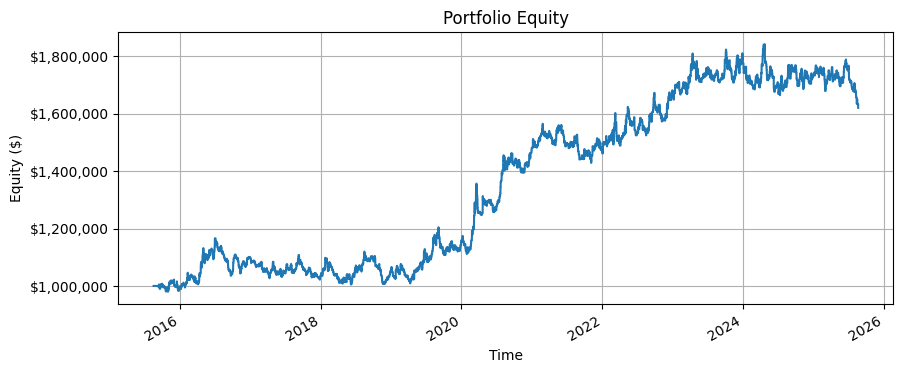

In [11]:
# Assuming `s` is the equity Series you already built
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Times + equity (portfolio). Safe to call anytime; uses the engine's live history.
times, equity = api.get_equity_series()   # None -> portfolio; pass a symbol for per-asset

n = min(len(times), len(equity))
if n == 0:
    print("No equity data available yet.")
else:
    s = pd.Series(equity[:n], index=pd.to_datetime(times[:n])).dropna()

    # (Optional) smooth gaps like weekends/holidays:
    s = s.resample("h").last().ffill()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(s.index, s.values)
    ax.set_title("Portfolio Equity")
    ax.set_xlabel("Time"); ax.set_ylabel("Equity ($)")
    ax.grid(True)
    
    # Turn off scientific notation/offset and format with commas
    ax.ticklabel_format(axis='y', style='plain', useOffset=False)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${x:,.0f}'))
    
    fig.autofmt_xdate()
    plt.show()


# But Wait! We can do better!

## Adding Intelligence to the Exit: PPO-Selected Trailing Stops

The first run used a **fixed 3× ATR trailing stop**—faithful to the Basso demo and great for illustrating the importance of risk management. Next, we’ll upgrade the exit with a small dose of machine learning: a **PPO-based policy** that **selects the ATR multiple dynamically** (e.g., choose 1×, 2×, 3×, or 4× ATR) based on recent market context.

### Why this can help
- **Regime-aware stops:** Quiet, mean-reverting markets often benefit from **tighter** stops; volatile/trending regimes often need **looser** stops to avoid whipsaw.  
- **More consistent expectancy:** By adjusting the distance intelligently, the exit aims to **reduce avoidable stop-outs** without choking off winners.  
- **No look-ahead, still disciplined:** The policy only sees **previously closed-bar features**; entries/exits remain rule-based and reproducible.

### How it works here
- **Training data:** We generated offline data by scanning several ATR multiples and recording which one would have performed best at each eligible entry.  
- **Features (prev bar only):** `ATR`, `RSI(14)`, `EMA(21)`, `Close`, and a **position flag** (+1 long / −1 short).  
- **Model:** A PPO classifier maps features → a **discrete ATR multiple** (`{1,2,3,4}` by default).  
- **Execution:** At entry and on each bar while trailing, the policy proposes `K×ATR`. The stop is ratcheted forward **only** when price has moved favorably past entry (never loosens).  
- **Safety:** If a model is missing for a symbol (or SB3 isn’t available), we **fall back to 3× ATR** so the run remains consistent.

### What to expect
- **Similar win rate, improved *profit factor*** in persistent regimes (fewer “too-tight” stop-outs).  
- **Smoother per-asset equity** when trend strength/volatility shifts.  
- **Still Basso-style:** random entries, disciplined exits—now **context-sensitive**.


## Imports

In [12]:
from PyQt5 import QtWidgets
import gc

from classes.Backtester_Engine import BacktesterEngine
from classes.Trading_Environment import TradingEnvironment
from classes.ui_main_window import launch_gui

# Bots
from bots.coin_flip_bot.coin_flip_bot import CoinFlipBot
from bots.trend_following_bot.trend_following_bot import TrendFollowingBot

# Exits
from bots.exit_strategies import TrailingATRExit, FixedRatioExit, RLTrailingATRExit

## Generate ML training data

In [13]:
!PYTHONPATH=. python3 bots/generate_ML_SL_Training_data.py \
  --config bots/configs/ml_sl_config.yaml \
  --output-dir bots/data/yahoo_finance/training_data

Processing 6B=F (yahoo_finance/data/Futures/British_Pound/1Day_timeframe/british_pound_2000-2015.csv)... range [100, 3792)
6B=F: 100%|################################| 3692/3692 [00:26<00:00, 141.07it/s]
Saved to bots/data/yahoo_finance/training_data/rl_stop_loss_training_6B=F.csv
Processing CL=F (yahoo_finance/data/Futures/Crude_Oil/1Day_timeframe/crude_oil_2000-2015.csv)... range [100, 3792)
CL=F: 100%|################################| 3692/3692 [00:29<00:00, 125.56it/s]
Saved to bots/data/yahoo_finance/training_data/rl_stop_loss_training_CL=F.csv
Processing 6E=F (yahoo_finance/data/Futures/Euro/1Day_timeframe/euro_2000-2015.csv)... range [100, 3792)
6E=F: 100%|################################| 3692/3692 [00:35<00:00, 103.82it/s]
Saved to bots/data/yahoo_finance/training_data/rl_stop_loss_training_6E=F.csv
Processing GC=F (yahoo_finance/data/Futures/Gold/1Day_timeframe/gold_2000-2015.csv)... range [100, 3792)
GC=F: 100%|#################################| 3692/3692 [00:39<00:00, 93.43

## Train PPO stop‑loss selector

In [14]:
!PYTHONPATH=. python3 bots/train_ppo_stop_selector.py \
  --input_dir bots/data/yahoo_finance/training_data \
  --output_dir bots/models/PPO_Trailing_Stop_Loss \
  --total_timesteps 300000


[TRAIN] 6B=F — rows: 7326, actions: [1.0, 2.0, 3.0, 4.0], envs: 8
Using cpu device
------------------------------
| time/              |       |
|    fps             | 21222 |
|    iterations      | 1     |
|    time_elapsed    | 0     |
|    total_timesteps | 8192  |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 19779       |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.013843633 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.0171     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0313      |
|    n_updates            | 6           |
|    policy_gradient_loss | -0.0707     |
|    value_loss           |

## Build the PPO RL exit strategy

In [15]:
# ML Trailing Stop Loss Exits
PPO_Models_Dir = "bots/models/PPO_Trailing_Stop_Loss"

# ML Trailing Stop Loss using PPO or LSTM models
exit_strategy = RLTrailingATRExit(
    model_dir=PPO_Models_Dir,
    fallback_multiple=3.0,   # used if a symbol has no model or SB3 isn't available
    ema_span=21,             # use 21 by default; you can sync this to your bot's EMA below
    debug=False,             # set True to print load/inference fallbacks
)

## Build the bot with the new exit strategy

In [16]:
bot = TrendFollowingBot(
    exit_strategy=exit_strategy,
    base_risk_percent=0.01,
    enforce_sessions=False,
    flatten_before_maintenance=True,
    enable_online_learning=False
)

## Initialize engine and environment

In [17]:
config_path = "backtest_configs/backtest_config_10_yrs.yaml"

api = BacktesterEngine(config_path=config_path)
api.connect()

env = TradingEnvironment()
env.set_api(api)
env.set_bot(bot)

# Initial indicator compute happens inside TradingEnvironment on connect.
print('Assets:', env.get_asset_list())


Assets: ['6B=F', 'CL=F', '6E=F', 'GC=F', 'LE=F', 'SI=F', 'ZS=F', 'ZB=F']


## Launch GUI and Run Backtest

In [18]:
launch_gui(env, api)

[FORCED LIQUIDATION] 6E=F: current qty=42, submitting side=sell, qty=42
[FORCED LIQUIDATION] GC=F: current qty=12, submitting side=sell, qty=12
[FORCED LIQUIDATION] ZB=F: current qty=48, submitting side=sell, qty=48
[FORCED LIQUIDATION] ZS=F: current qty=71, submitting side=sell, qty=71
[FORCED LIQUIDATION] CL=F: current qty=-30, submitting side=buy, qty=30


## Backtesting Results

### Show Statistics

In [19]:
# Minimal: pull stats from the running/backtested engine and show them inline

import pandas as pd
from IPython.display import display

stats = api.get_stats_snapshot()   # live snapshot; safe to call anytime

# Portfolio (one row)
display(pd.DataFrame([{
    "Initial Cash":   stats["portfolio"].get("initial_cash", 0.0),
    "Final Equity":   stats["portfolio"].get("total_equity", 0.0),
    "Used Margin":    stats["portfolio"].get("used_margin", 0.0),
    "Max Drawdown %": 100.0 * stats["portfolio"].get("max_drawdown", 0.0),
}]))

# Per-asset table
display(pd.DataFrame.from_dict(stats["per_asset"], orient="index").reset_index().rename(columns={"index":"Symbol"}))


,Initial Cash,Final Equity,Used Margin,Max Drawdown %
0,1000000.0,5.889556e+06,0.0,28.627453


,Symbol,trades,wins,losses,long_trades,short_trades,win_rate,avg_win,avg_loss,profit_factor,expectancy,commission_total,fee_total,max_drawdown
0,6B=F,348,132,216,179,169,0.379310,43896.354166,-21282.175925,1.260470,3440.714799,69756.0,1044.0,6.750011e+15
1,CL=F,305,114,191,166,139,0.373770,42802.719299,-26202.094240,0.975005,-410.131147,19052.0,915.0,2.814000e+16
2,6E=F,329,120,209,162,167,0.364742,38847.447917,-22993.869618,0.970030,-437.765957,42996.0,987.0,3.500225e+14
3,GC=F,377,153,224,228,149,0.405836,55106.274517,-25677.008926,1.465885,7107.718837,23544.0,1131.0,8.715908e+00
4,LE=F,346,137,209,219,127,0.395954,44492.554747,-26838.899520,1.086668,1405.057805,57044.0,1038.0,2.970022e+15
5,SI=F,431,161,270,231,200,0.373550,55989.596275,-27616.111110,1.208946,3614.791185,27248.0,1293.0,1.497863e+01
6,ZS=F,331,111,220,166,165,0.335347,48919.594594,-26392.159091,0.935208,-1136.555891,44204.0,993.0,3.750000e+15
7,ZB=F,305,117,188,136,169,0.383607,42009.882476,-26481.216756,0.987283,-207.581968,30760.0,915.0,8.312057e+00


### Show Equity Curve

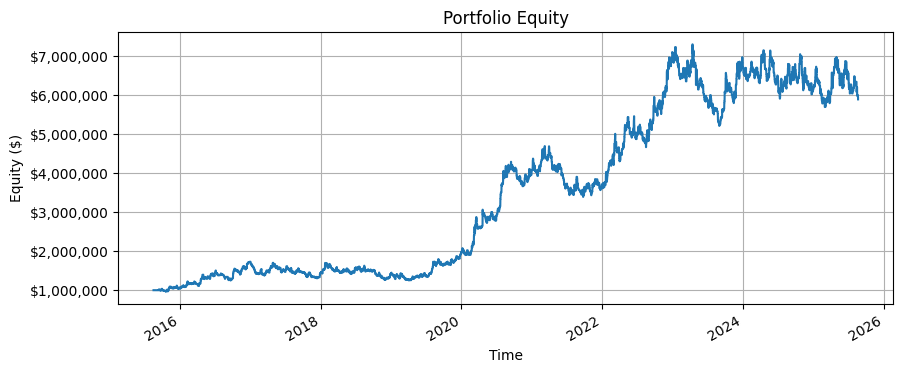

In [20]:
# Assuming `s` is the equity Series you already built
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Times + equity (portfolio). Safe to call anytime; uses the engine's live history.
times, equity = api.get_equity_series()   # None -> portfolio; pass a symbol for per-asset

n = min(len(times), len(equity))
if n == 0:
    print("No equity data available yet.")
else:
    s = pd.Series(equity[:n], index=pd.to_datetime(times[:n])).dropna()

    # (Optional) smooth gaps like weekends/holidays:
    s = s.resample("h").last().ffill()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(s.index, s.values)
    ax.set_title("Portfolio Equity")
    ax.set_xlabel("Time"); ax.set_ylabel("Equity ($)")
    ax.grid(True)
    
    # Turn off scientific notation/offset and format with commas
    ax.ticklabel_format(axis='y', style='plain', useOffset=False)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${x:,.0f}'))
    
    fig.autofmt_xdate()
    plt.show()
